In [62]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [64]:
# open data
tries = 1


def open_data(folder_name):
    output = {}
    with open(f"{folder_name}/coins.pkl", "rb") as f:
        output["coins"] = pickle.load(f)
    with open(f"{folder_name}/alphas.pkl", "rb") as f:
        output["alphas"] = pickle.load(f)
    with open(f"{folder_name}/errors.pkl", "rb") as f:
        output["errors"] = pickle.load(f)
    with open(f"{folder_name}/success.pkl", "rb") as f:
        output["success"] = pickle.load(f)
    with open(f"{folder_name}/c_list.pkl", "rb") as f:
        output["c_list"] = pickle.load(f)
    return output


mechanisms = []
eps_list = [0.5, 1, 1.5]
B_exp = 9
N = 5000
for exp in eps_list:
    folder_name = f"results/BaySS/find_alpha_{tries}/N_{N}/B_exp_{B_exp}/eps_{exp:.1f}"
    output = open_data(folder_name)
    output["label"] = f"BaySS, eps: {exp}"
    mechanisms.append(output)

def upload_data(N: int, B_exp: int):
    folder_name = f"data/N_{N}/B_exp_{B_exp}"
    output = {}
    # import data
    with open(f'{folder_name}/pareto_data.pkl', 'rb') as f:
        data = pickle.load(f)
    output["data"] = data

    # import bins
    with open(f'{folder_name}/pareto_bins.pkl', 'rb') as f:
        bins = pickle.load(f)
    output["bins"] = bins

    # import intervals
    with open(f'{folder_name}/pareto_intervals.pkl', 'rb') as f:
        intervals = pickle.load(f)
    output["intervals"] = intervals

    # import median
    with open(f'{folder_name}/pareto_median.pkl', 'rb') as f:
        median = pickle.load(f)
    output["median"] = median

    # import median quantile
    with open(f'{folder_name}/pareto_median_quantile.pkl', 'rb') as f:
        median_quantile = pickle.load(f)
    output["median_quantile"] = median_quantile

    # import cdf
    with open(f'{folder_name}/pareto_cdf.pkl', 'rb') as f:
        cf_dict = pickle.load(f)
    output["cf_dict"] = cf_dict

    return output


data = upload_data(N, B_exp)


In [65]:
markers = ["-", "--", "-.", ":", "-o", "-s", "-D", "-^", "-v", "-<", "->", "-p", "-h"]
colors = ["blue", "red", "green", "orange", "purple", "black", "brown", "pink", "gray", "olive", "cyan", "magenta"]

# Success rate

In [66]:
def get_binomial_std(p, n):
    return np.sqrt(p * (1 - p) / n)

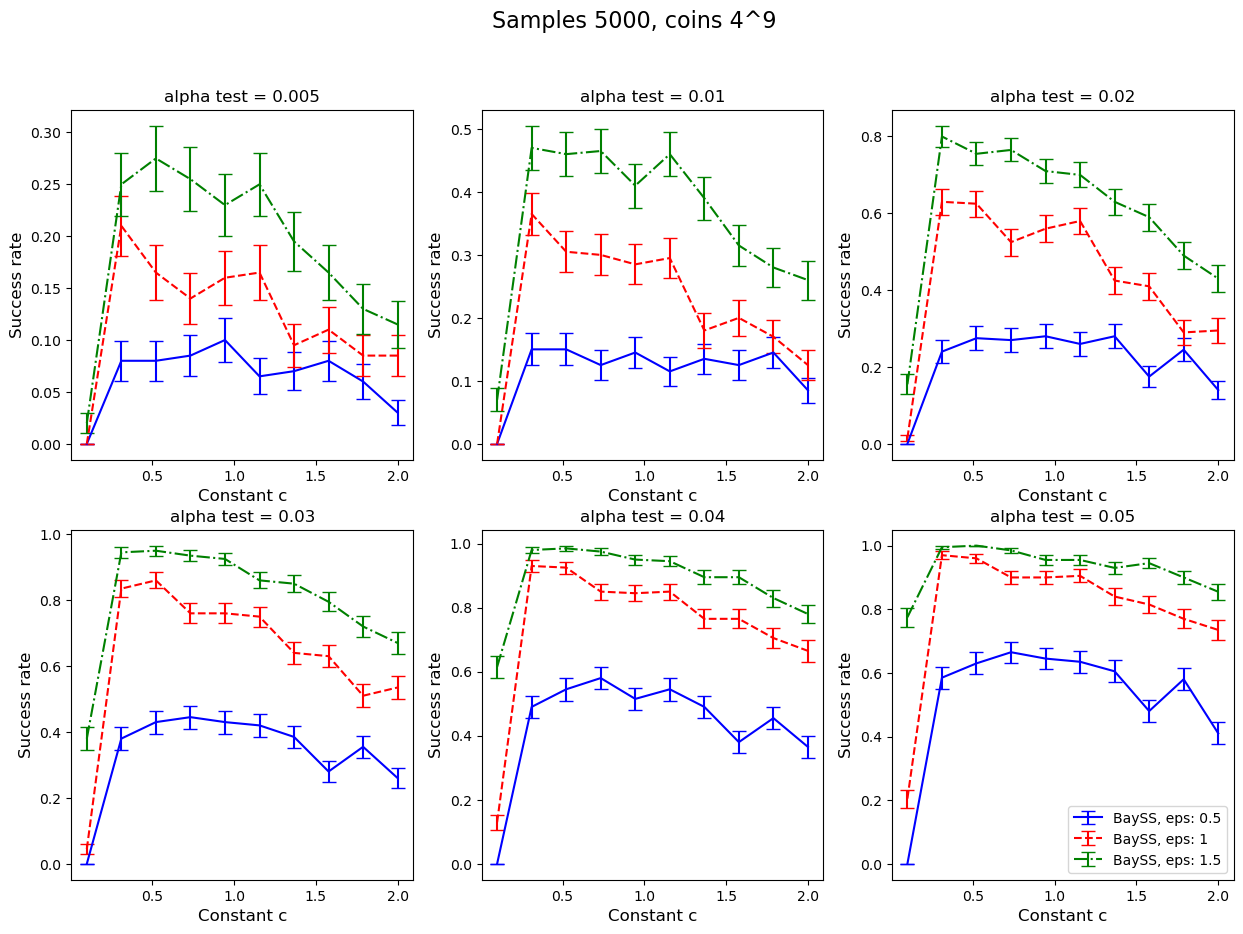

In [67]:
def get_success(coin, cf_dict, alpha, target):
    coin = int(coin)
    if coin not in cf_dict.keys():
        for index in reversed(range(coin)):
            if index in cf_dict.keys():
                coin = index
                break
    if target - alpha < cf_dict[coin] < target + alpha:
        success = True
    else:
        success = False
    return int(success)


fig, axs = plt.subplots(2, 3, figsize=(15, 10))
alpha_test_list = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index // 3, fig_index % 3]  # Access subplot correctly
    for i, output in enumerate(mechanisms):
        c_list = output["c_list"]
        coins = output["coins"]
        success = np.zeros((len(c_list), len(coins[0])))
        for j in range(len(c_list)):
            for c, coin in enumerate(coins[j]):
                success[j, c] = get_success(coin, data["cf_dict"], alpha_test, 0.5)
        ax.errorbar(c_list,
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=output["label"],
                    color=colors[i],
                    capsize=5)
    ax.set_xlabel("Constant c", fontsize=12)
    ax.set_ylabel("Success rate", fontsize=12)
    ax.set_title(f"alpha test = {alpha_test}")

fig.suptitle(f"Samples {N}, coins 4^{B_exp}", fontsize=16)
plt.legend()

# save fig
folder_name = "find_alpha"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/success_vs_eps_N_{N}_Bexp_{B_exp}.pdf")
plt.show()

# Error vs. $\varepsilon$ plot

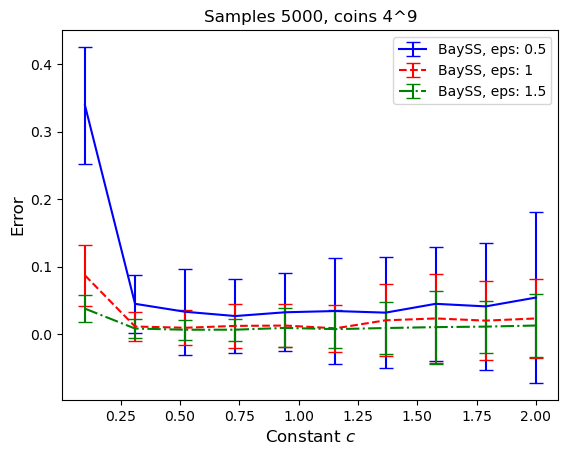

In [49]:
for i, output in enumerate(mechanisms):
    errors = output["errors"]
    c_list = output["c_list"]
    plt.errorbar(c_list,
                 np.mean(errors, axis=1),
                 yerr=np.std(errors, axis=1),
                 fmt=markers[i],
                 label=output["label"],
                 color=colors[i],
                 capsize=5)
plt.xlabel(r'Constant $c$', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title(f"Samples {N}, coins 4^{B_exp}")
plt.legend()
# plt.savefig(os.path.join("figures", folder_name, figure_name))

folder_name = "find_alpha"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/errors_N_{N}_Bexp_{B_exp}.pdf")

plt.show()

# CDF of errors

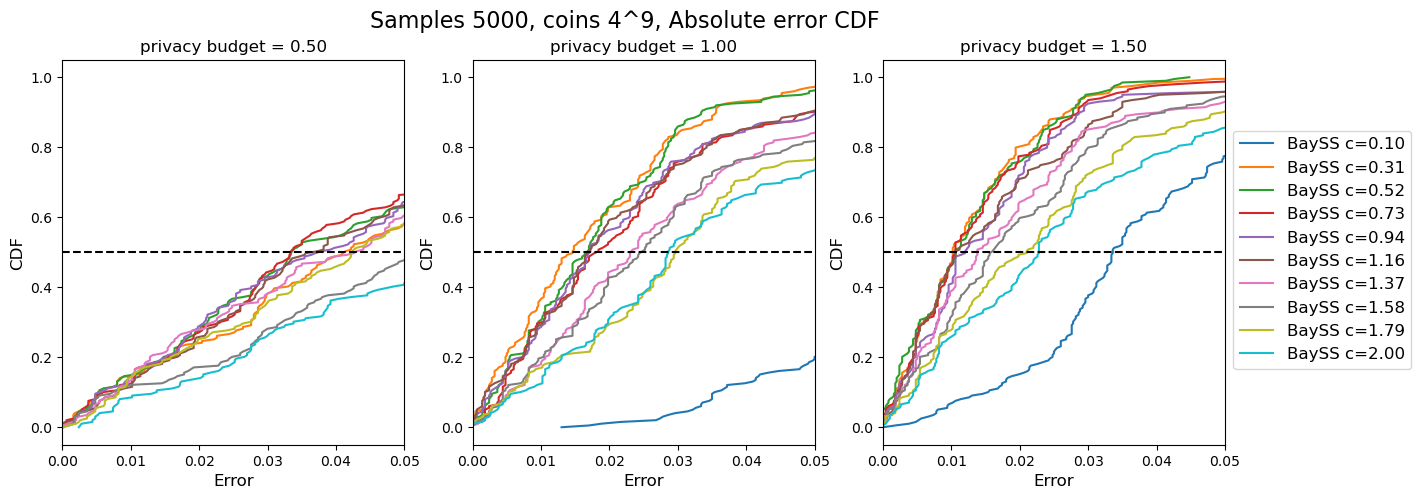

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for fig_index, eps in enumerate(eps_list):
    ax = axs[fig_index]  # Access subplot correctly
    
    output = mechanisms[fig_index]
    c_list = output["c_list"]
    errors = output["errors"]
    for i, c in enumerate(c_list):
        error = np.sort(np.abs(errors[i]))
        error = error[::-1]
        ax.plot(error, np.linspace(1, 0, len(error)), label=f"BaySS c={c:.2f}")
    ax.set_xlabel('Error', fontsize=12)
    ax.set_ylabel('CDF', fontsize=12)
    ax.set_title(f"privacy budget = {eps:.2f}")
    ax.set_xlim(0, 0.05)
    # set horizontal line at 0.5
    ax.axhline(y=0.5, color='black', linestyle='--')

handles, labels = ax.get_legend_handles_labels()
fig.suptitle(f"Samples {N}, coins 4^{B_exp}, Absolute error CDF", fontsize=16)
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12)

# save fig
folder_name = "find_alpha"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/abs_errors_cdf_N_{N}_Bexp_{B_exp}.pdf", bbox_inches='tight')

plt.show()